In [2]:
import random
import openpyxl
import warnings
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

**Importacion de librerias necesarias**

**Sustentacion**

Link donde se obstuvo la informacion: https://www.kaggle.com/datasets/katerynameleshenko/cyber-security-indexes

In [3]:
#Analizamos el dataset de kaggle
file_path = 'Cyber_security.csv'  
data = pd.read_csv(file_path)
# Mostrar las primeras filas del DataFrame
display(data.head())

,Country,Region,CEI,GCI,NCSI,DDL
0,Afghanistan,Asia-Pasific,1.000,5.20,11.69,19.50
1,Albania,Europe,0.566,64.32,62.34,48.74
2,Algeria,Africa,0.721,33.95,33.77,42.81
3,Andorra,Europe,NaN,26.38,NaN,NaN
4,Angola,Africa,NaN,12.99,9.09,22.69


**Explicacion columnas dataset**

CEI (Cybersecurity Exposure Index): Este índice mide la exposición de los países al cibercrimen, es decir, qué tan vulnerables son frente a ciberataques. Un valor más alto indica mayor exposición.

GCI (Global Cyber Security Index): El GCI mide el compromiso de un país con la ciberseguridad a nivel institucional. Evalúa la capacidad legal, técnica, organizativa, de cooperación y desarrollo de capacidades de un país para enfrentar ciberamenazas.

NCSI (National Cyber Security Index): El NCSI mide la preparación de un país para enfrentar ciberamenazas y su capacidad para manejar incidentes cibernéticos. Se evalúan las políticas y capacidades nacionales para prevenir, detectar, gestionar y mitigar ciberamenazas.

DDL (Digital Development Level): Este índice refleja el promedio de los puntajes obtenidos en los índices anteriores y evalúa el nivel general de desarrollo digital de un país.


- CEI (Cybersecurity Exposure Index - Índice de Exposición a la Ciberseguridad): age, online_time, y spam_emails_received
- GCI (Global Cyber Security Index - Índice Global de Ciberseguridad): education_level y cybersecurity_knowledge.
- NCSI (National Cyber Security Index - Índice Nacional de Ciberseguridad): password_change_frequency, uses_2FA, uses_antivirus y software_update_frequency, uses_vpn
- DDL (Digital Development Level - Nivel de Desarrollo Digital): social_media_privacy_setting, uses_fingerprint

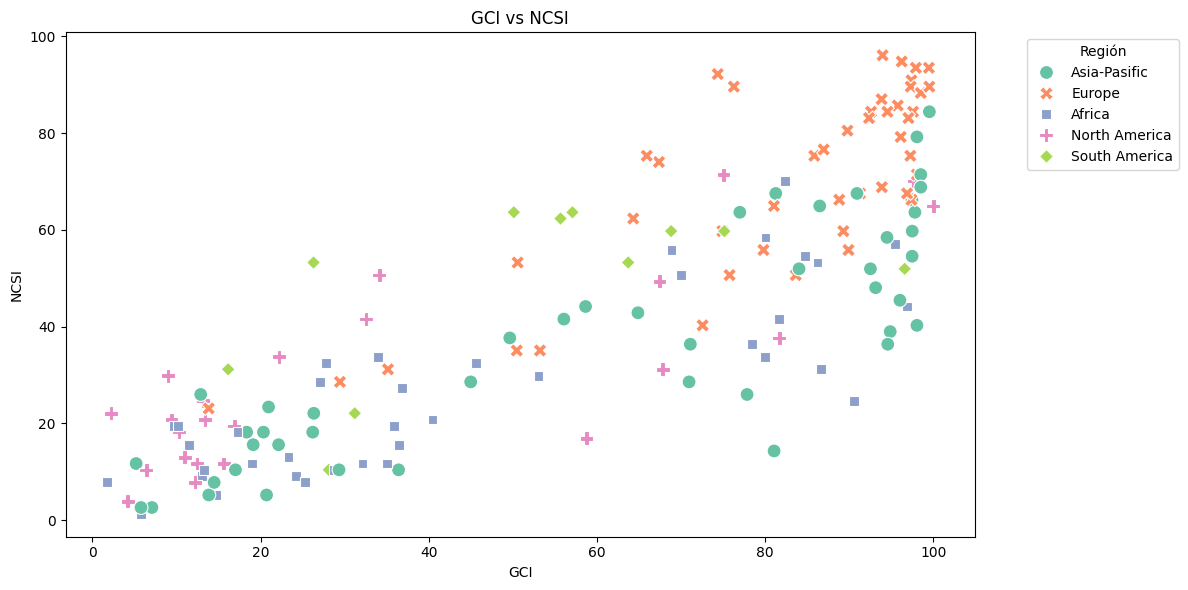

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='GCI', y='NCSI', data=data, hue='Region', style='Region', palette='Set2', s=100)
plt.title('GCI vs NCSI')
plt.xlabel('GCI')
plt.ylabel('NCSI')
plt.legend(title='Región', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [5]:
# Filtrar solo los países de interés
countries_of_interest = ['Peru', 'Albania', 'Algeria', 'Andorra', 'Angola']
filtered_data = data[data['Country'].isin(countries_of_interest)]


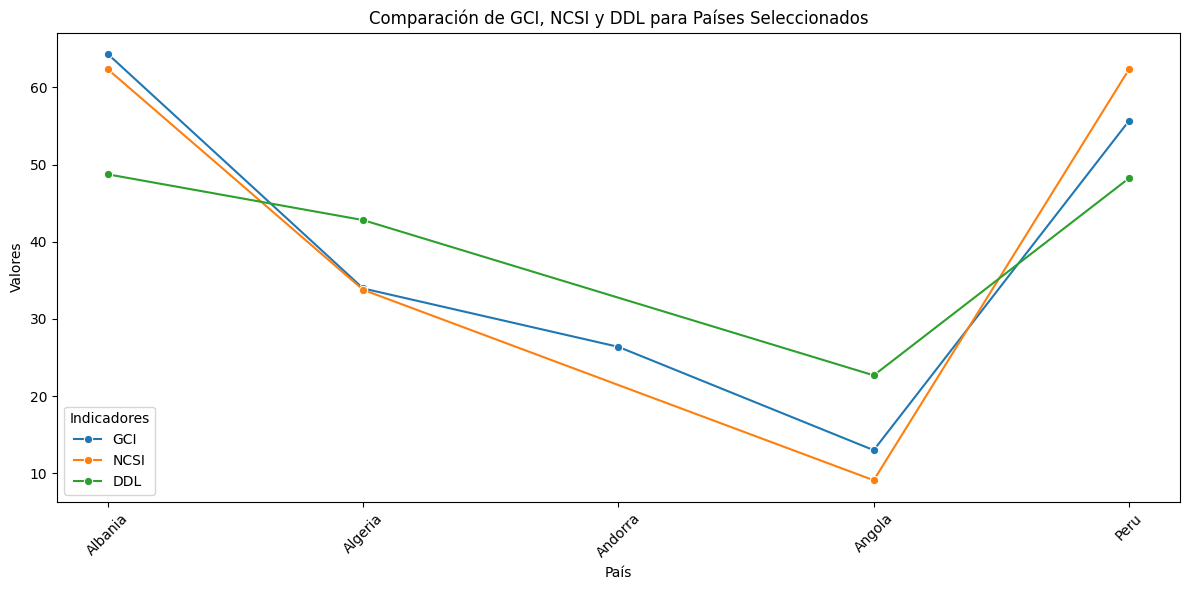

In [6]:
plt.figure(figsize=(12, 6))
for column in ['GCI', 'NCSI', 'DDL']:
    sns.lineplot(x='Country', y=column, data=filtered_data, marker='o', label=column)

plt.title('Comparación de GCI, NCSI y DDL para Países Seleccionados')
plt.xlabel('País')
plt.ylabel('Valores')
plt.legend(title='Indicadores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


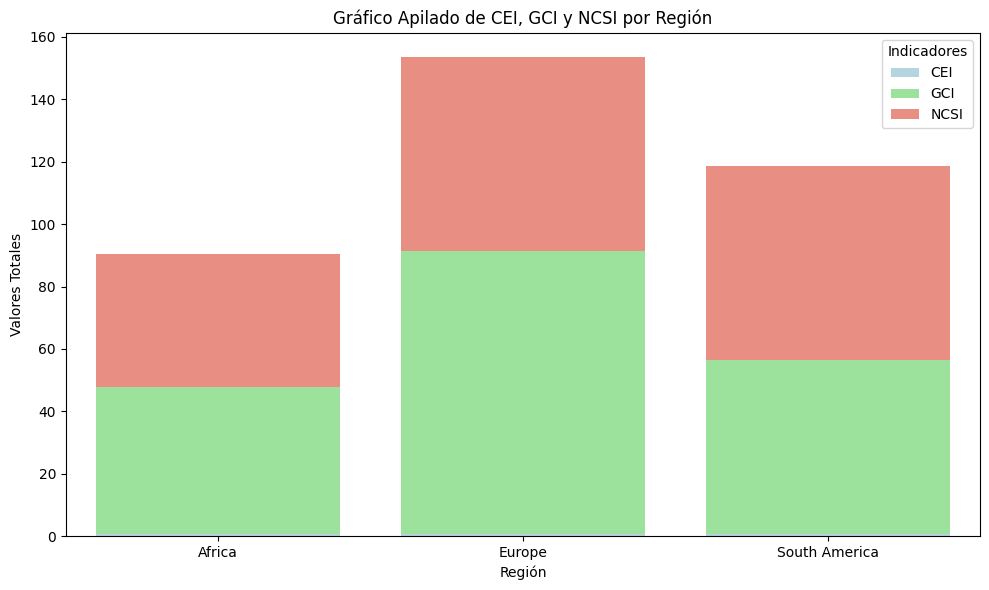

In [7]:
# Preparar los datos para el gráfico apilado
stacked_data = filtered_data.groupby('Region').sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='CEI', data=stacked_data, color='lightblue', label='CEI')
sns.barplot(x='Region', y='GCI', data=stacked_data, color='lightgreen', label='GCI', bottom=stacked_data['CEI'])
sns.barplot(x='Region', y='NCSI', data=stacked_data, color='salmon', label='NCSI', bottom=stacked_data['CEI'] + stacked_data['GCI'])

plt.title('Gráfico Apilado de CEI, GCI y NCSI por Región')
plt.xlabel('Región')
plt.ylabel('Valores Totales')
plt.legend(title='Indicadores')
plt.tight_layout()
plt.show()


**Lectura de data original**

In [8]:
dataframe = "data_original.xlsx"

# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(dataframe)

# Mostrar las primeras 5 filas del DataFrame de manera más profesional
display(df.head())


,age,education_level,cybersecurity_knowledge,online_time,password_change_frequency,uses_2FA,uses_antivirus,software_update_frequency,uses_vpn,spam_emails_received,social_media_privacy_setting,uses_fingerprint,registration_date,phishing_susceptibility
0,63.0,Secundaria,Alto,58.0,Baja,Sí,Sí,Baja,No,58.0,Media,Sí,2024-06-06,Susceptible
1,60.0,Universitario,Bajo,180.0,Baja,No,Sí,Alta,Sí,79.0,Alta,No,2024-04-12,Susceptible
2,75.0,Secundaria,Bajo,157.0,Alta,Sí,No,Baja,Sí,63.0,Baja,No,2023-12-17,Susceptible
3,54.0,Secundaria,Bajo,115.0,Media,No,No,Alta,No,5.0,Media,No,2022-12-24,Susceptible
4,25.0,NaN,Medio,86.0,Alta,Sí,Sí,Alta,No,27.0,Alta,No,2023-06-15,Susceptible


**Limpieza de data**

In [9]:
# Mostrar resumen de valores nulos en el DataFrame original
print("Valores faltantes antes de la limpieza:")
print(df.isnull().sum())  # Muestra la cantidad de valores nulos por columna en el DataFrame

# 2.1 Opción 1: Eliminar filas con valores nulos
df_cleaned = df.dropna()  # Crea un nuevo DataFrame eliminando filas que contengan al menos un valor nulo

# 3. Eliminar duplicados
df_cleaned = df_cleaned.drop_duplicates()  # Elimina filas duplicadas en el DataFrame limpio

# Mostrar el resumen después de la limpieza para verificar si se eliminaron los valores nulos
print("Valores faltantes después de la limpieza:")
print(df_cleaned.isnull().sum())  # Muestra la cantidad de valores nulos por columna en el DataFrame limpio

# Mostrar las primeras filas del DataFrame limpio para una revisión rápida
print(df_cleaned.head())  # Imprime las primeras 5 filas del DataFrame limpio


Valores faltantes antes de la limpieza:
age                             30077
education_level                 30125
cybersecurity_knowledge         27828
online_time                     29931
password_change_frequency       29566
uses_2FA                        30162
uses_antivirus                  28824
software_update_frequency       29088
uses_vpn                        29929
spam_emails_received            13791
social_media_privacy_setting    29836
uses_fingerprint                29989
registration_date               29998
phishing_susceptibility             0
dtype: int64
Valores faltantes después de la limpieza:
age                             0
education_level                 0
cybersecurity_knowledge         0
online_time                     0
password_change_frequency       0
uses_2FA                        0
uses_antivirus                  0
software_update_frequency       0
uses_vpn                        0
spam_emails_received            0
social_media_privacy_setting    0

 **1.1. PRE-PROCESAMIENTO DE DATOS**

 **1.2. EDA - Análisis Exploratorio de Datos**

In [10]:
df_cleaned.columns #Muestra las columnas del dataset

Index(['age', 'education_level', 'cybersecurity_knowledge', 'online_time',
       'password_change_frequency', 'uses_2FA', 'uses_antivirus',
       'software_update_frequency', 'uses_vpn', 'spam_emails_received',
       'social_media_privacy_setting', 'uses_fingerprint', 'registration_date',
       'phishing_susceptibility'],
      dtype='object')

In [11]:
# Mostrar información resumida del DataFrame limpio
df_cleaned.info()  # Proporciona un resumen sobre el DataFrame 'df_cleaned', incluyendo el número de entradas, tipos de datos, y la cantidad de valores no nulos en cada columna

<class 'pandas.core.frame.DataFrame'>
Index: 318397 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   age                           318397 non-null  float64
 1   education_level               318397 non-null  object 
 2   cybersecurity_knowledge       318397 non-null  object 
 3   online_time                   318397 non-null  float64
 4   password_change_frequency     318397 non-null  object 
 5   uses_2FA                      318397 non-null  object 
 6   uses_antivirus                318397 non-null  object 
 7   software_update_frequency     318397 non-null  object 
 8   uses_vpn                      318397 non-null  object 
 9   spam_emails_received          318397 non-null  float64
 10  social_media_privacy_setting  318397 non-null  object 
 11  uses_fingerprint              318397 non-null  object 
 12  registration_date             318397 non-null  ob

In [12]:
# Generar estadísticas descriptivas del DataFrame limpio
df_cleaned.describe()  # Proporciona un resumen estadístico de las columnas numéricas en 'df_cleaned', incluyendo la cuenta, media, desviación estándar, valores mínimo y máximo, y los cuartiles (25%, 50%, 75%)

,age,online_time,spam_emails_received
count,318397.000000,318397.000000,318397.000000
mean,45.480542,100.699812,52.837323
std,25.965875,57.782761,27.761044
min,1.000000,1.000000,0.000000
25%,23.000000,51.000000,29.000000
50%,46.000000,101.000000,53.000000
75%,68.000000,151.000000,77.000000
max,90.000000,200.000000,100.000000


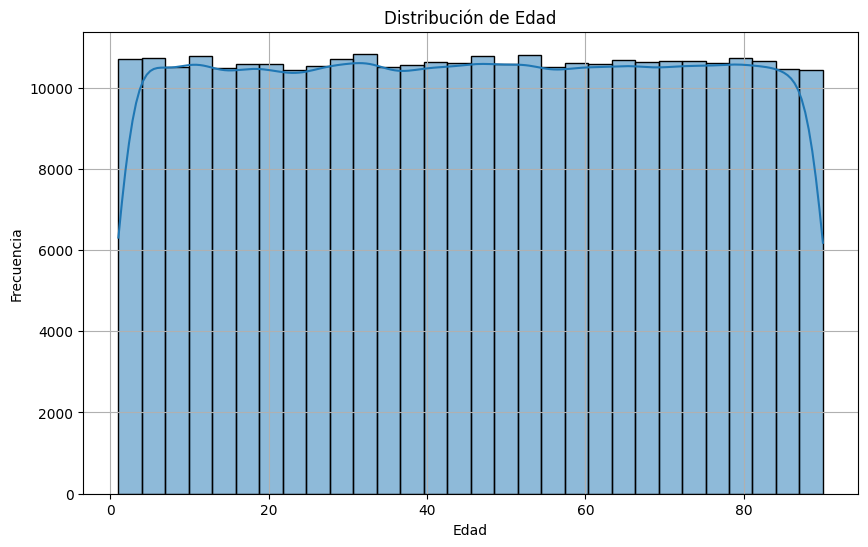

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['age'].dropna(), bins=30, kde=True)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

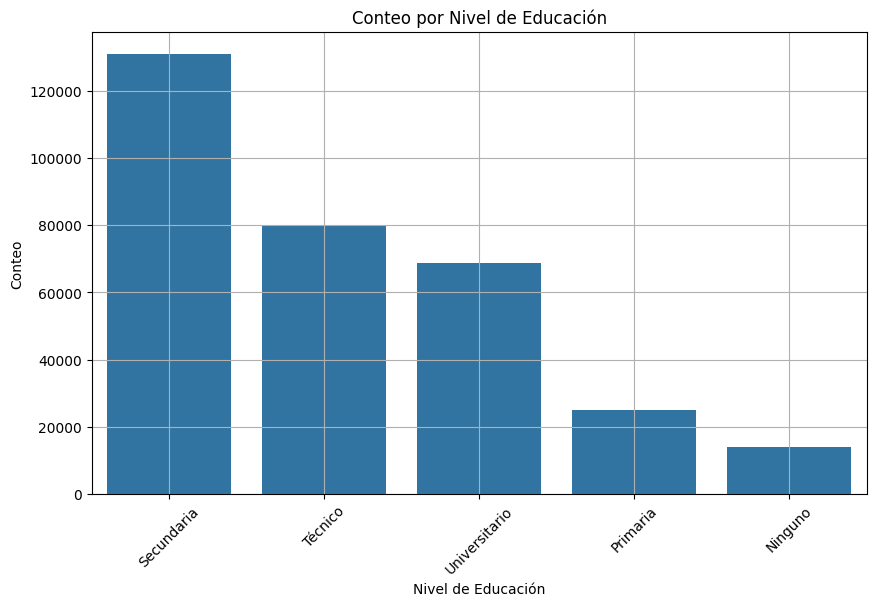

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='education_level', order=df['education_level'].value_counts().index)
plt.title('Conteo por Nivel de Educación')
plt.xlabel('Nivel de Educación')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.grid()
plt.show()


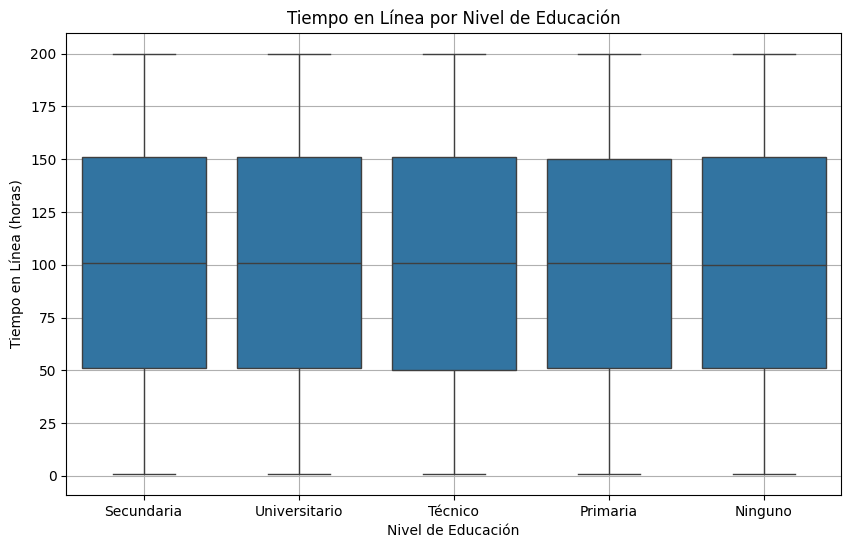

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='education_level', y='online_time')
plt.title('Tiempo en Línea por Nivel de Educación')
plt.xlabel('Nivel de Educación')
plt.ylabel('Tiempo en Línea (horas)')
plt.grid()
plt.show()

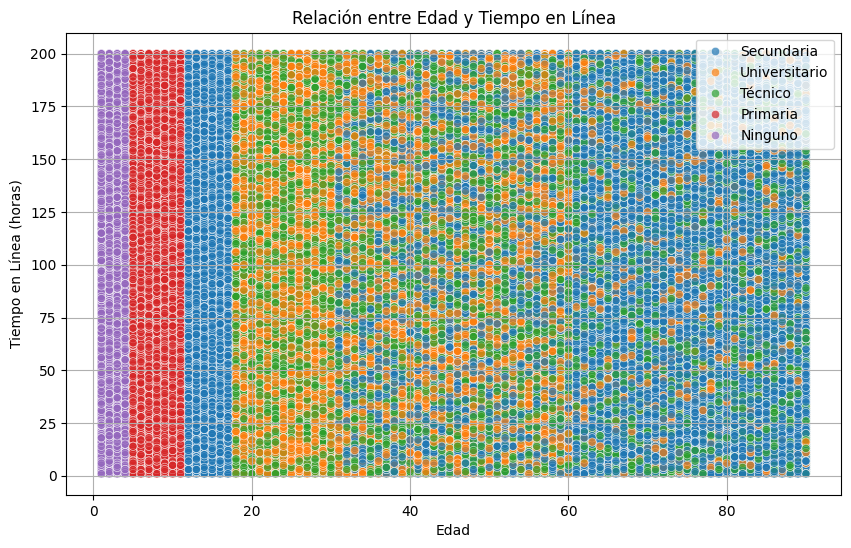

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='age', y='online_time', hue='education_level', alpha=0.7)
plt.title('Relación entre Edad y Tiempo en Línea')
plt.xlabel('Edad')
plt.ylabel('Tiempo en Línea (horas)')
plt.grid()
plt.legend(loc='upper right') 
plt.show()


 **Generacion de escenarios**

In [ ]:
# Ignorar advertencias
warnings.filterwarnings("ignore", category=UserWarning)

# Ignorar advertencias de tipo FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Encabezados de las columnas en inglés con columnas adicionales
columnas = [
    "age", "education_level", "cybersecurity_knowledge",
    "online_time", "password_change_frequency", "uses_2FA",
    "uses_antivirus", "software_update_frequency", "uses_vpn",
    "spam_emails_received", "social_media_privacy_setting",
    "uses_fingerprint", "registration_date", "phishing_susceptibility"
]

df_final_aumentada = pd.DataFrame(columns=columnas)

# Función para generar datos coherentes
def generar_datos_aleatorios_mejorados(num_filas):
    # Niveles de educación y ciberseguridad
    niveles_ciberseguridad = ["Bajo", "Medio", "Alto"]
    frecuencia_cambio_contrasena_opciones = ["Alta", "Media", "Baja"]
    frecuencia_actualizacion_opciones = ["Alta", "Media", "Baja"]

    # Contador de clases y tamaño por clase
    contador_clases = {
        "No susceptible": 0,
        "Levemente susceptible": 0,
        "Moderadamente susceptible": 0,
        "Susceptible": 0
    }
    
    max_filas_por_clase = num_filas // 4  # Limita el número de filas por clase

    # Función para asignar nivel educativo según la edad
    def asignar_nivel_educativo(edad):
        if edad < 5:
            return "Ninguno"
        elif 5 <= edad <= 11:
            return "Primaria"
        elif 12 <= edad <= 17:
            return "Secundaria"
        elif 18 <= edad <= 22:
            return random.choice(["Técnico", "Universitario"])
        elif 23 <= edad <= 30:
            return random.choice(["Técnico", "Universitario"])
        elif 31 <= edad <= 60:
            return random.choice(["Técnico", "Universitario", "Secundaria"])
        else:  # Más de 60 años
            return random.choices(["Secundaria", "Técnico", "Universitario"], weights=[0.7, 0.2, 0.1])[0]

    # Generar datos hasta alcanzar el número de filas deseado
    datos = []
    while sum(contador_clases.values()) < num_filas:
        # Generación de características coherentes
        edad = random.randint(1, 90)
        nivel_educacion = asignar_nivel_educativo(edad)
        conocimiento_ciberseguridad = random.choice(niveles_ciberseguridad)
        tiempo_en_linea = random.randint(1, 200)  # Horas por semana
        frecuencia_cambio_contrasena = random.choice(frecuencia_cambio_contrasena_opciones)
        usa_autenticacion_2FA = random.choices(["Si", "No"], weights=[0.6, 0.4])[0]  # Más probabilidades de "Si"
        usa_antivirus = random.choices(["Si", "No"], weights=[0.7, 0.3])[0]  # Más probabilidades de "Si"
        frecuencia_actualizacion_software = random.choice(frecuencia_actualizacion_opciones)

        # Nuevas columnas adicionales
        usa_vpn = random.choice(["Si", "No"])
        spam_emails_recibidos = random.randint(0, 900)  # Número de correos spam recibidos por semana
        configuracion_privacidad_redes_sociales = random.choice(["Alta", "Media", "Baja"])
        usa_fingerprint = random.choice(["Si", "No"])
        
        # Generar fecha de registro
        fecha_registro = datetime.now() - timedelta(days=random.randint(0, 365))

        # Cálculo probabilístico para asignar susceptibilidad
        susceptibilidad = None

        # Clasificación de susceptibilidad según las condiciones
        if contador_clases["No susceptible"] < max_filas_por_clase:
            if (conocimiento_ciberseguridad in ["Medio", "Alto"] and
                usa_antivirus == "Si" and frecuencia_cambio_contrasena == "Alto" and
                frecuencia_actualizacion_software == "Alta" and
                configuracion_privacidad_redes_sociales == "Alta" and  usa_fingerprint == "Si"):
                susceptibilidad = "No susceptible"
        
        if contador_clases["Levemente susceptible"] < max_filas_por_clase:
            if (conocimiento_ciberseguridad in ["Medio", "Alto"] and
                usa_antivirus == "Si" and
                frecuencia_cambio_contrasena == "Media" and
                usa_vpn == "Si" and  usa_fingerprint == "Si"):
                susceptibilidad = "Levemente susceptible"

        if contador_clases["Moderadamente susceptible"] < max_filas_por_clase:
            if (conocimiento_ciberseguridad == "Medio" and 
                (usa_antivirus == "No" or 
                frecuencia_actualizacion_software == "Media" or 
                spam_emails_recibidos > 5 or usa_fingerprint == "No")):
                susceptibilidad = "Moderadamente susceptible"

        if contador_clases["Susceptible"] < max_filas_por_clase:
            if (conocimiento_ciberseguridad == "Bajo" and 
                (usa_antivirus == "No" or 
                usa_autenticacion_2FA == "No" or 
                configuracion_privacidad_redes_sociales == "Baja" or usa_fingerprint == "No")):
                susceptibilidad = "Susceptible"

        # Si se asigna una susceptibilidad y no ha superado el límite, agregar los datos
        if susceptibilidad:
            datos.append([
                edad,
                nivel_educacion,
                conocimiento_ciberseguridad,
                tiempo_en_linea,
                frecuencia_cambio_contrasena,
                usa_autenticacion_2FA,
                usa_antivirus,
                frecuencia_actualizacion_software,
                usa_vpn,
                spam_emails_recibidos,
                configuracion_privacidad_redes_sociales,
                usa_fingerprint,
                fecha_registro.strftime("%Y-%m-%d"),  # Formato de fecha
                susceptibilidad
            ])
            contador_clases[susceptibilidad] += 1

    return datos

# Generar 600,000 filas con balance de clases
datos_generados = generar_datos_aleatorios_mejorados(500)

# Crear DataFrame con los datos generados
df_final_aumentada_generada = pd.DataFrame(datos_generados, columns=columnas)

# Concatenar con el DataFrame df_cleaned
df_final_aumentada = pd.concat([df_cleaned, df_final_aumentada_generada], ignore_index=True)

 #**Logistic Regression**

 **Entrenamiento Logistic Regression**

In [ ]:
# Ignorar advertencias
warnings.filterwarnings("ignore", category=UserWarning)

# Usar df_final_aumentada en lugar de cargar un archivo
df = df_final_aumentada.copy()  # Hacemos una copia del DataFrame 'df_final_aumentada' para evitar modificar el original.

# Convertir las columnas categóricas en numéricas
label_encoders = {}
for column in ['education_level', 'cybersecurity_knowledge',
               'password_change_frequency', 'uses_2FA',
               'uses_antivirus', 'software_update_frequency', 'phishing_susceptibility',
               'uses_vpn', 'spam_emails_received', 'social_media_privacy_setting', 'uses_fingerprint']:
    label_encoders[column] = LabelEncoder()  # Inicializa un codificador para cada columna categórica.
    df[column] = label_encoders[column].fit_transform(df[column])  # Convierte los valores categóricos en enteros.

# Guardar los LabelEncoders para uso futuro
for name, encoder in label_encoders.items():
    joblib.dump(encoder, f'label_encoder_{name}.pkl')  # Guarda cada codificador en un archivo .pkl.

# Verifica que los datos categóricos hayan sido convertidos correctamente
print("Datos después de la conversión de categóricos a numéricos:")
print(df.head())  # Muestra las primeras filas del DataFrame para verificar la conversión.

# Seleccionar las columnas relevantes como características (features) y objetivo (target)
features = df[['age', 'education_level', 'cybersecurity_knowledge',
               'online_time', 'password_change_frequency',
               'uses_2FA', 'uses_antivirus',
               'software_update_frequency', 'uses_vpn', 'spam_emails_received', 'social_media_privacy_setting', 'uses_fingerprint']]
target = df['phishing_susceptibility']  # La variable objetivo es 'phishing_susceptibility'.

# Escalar las columnas numéricas para mejorar el rendimiento del modelo
scaler = StandardScaler()  # Inicializa el escalador.
features_scaled = features.copy()  # Crea una copia de las características para aplicar el escalado.
features_scaled[['age', 'online_time']] = scaler.fit_transform(features_scaled[['age', 'online_time']])  # Escala las características seleccionadas.

# Guardar el scaler para uso futuro
joblib.dump(scaler, 'scaler.pkl')  # Guarda el escalador en un archivo .pkl.

# Balanceo de datos con SMOTE para manejar el desbalance de clases
X_balanced, y_balanced = None, None  # Inicializa las variables para almacenar los datos balanceados.

try:
    smote = SMOTE(random_state=42, k_neighbors=2)  # Inicializa SMOTE con un valor fijo de k_neighbors.
    X_balanced, y_balanced = smote.fit_resample(features_scaled, target)  # Aplica SMOTE para balancear las clases.
except ValueError as e:
    print(f"Ocurrió un error al aplicar SMOTE: {e}")  # Captura y muestra errores si ocurren al aplicar SMOTE.

# Imprime la distribución original y después de SMOTE
print("\nDistribución original de clases:")
print(target.value_counts())  # Muestra la distribución de las clases en el conjunto original.

if y_balanced is not None:
    print("\nDistribución después de SMOTE:")
    print(y_balanced.value_counts())  # Muestra la distribución de las clases después de aplicar SMOTE.
else:
    print("\nNo se pudo crear y_balanced debido a un error en SMOTE.")
    exit()  # Termina el script si no se pudo crear y_balanced.

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)  # Divide los datos, reservando el 30% para pruebas.

# Verifica los tamaños de los conjuntos de entrenamiento y prueba
print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]}")  # Imprime el tamaño del conjunto de entrenamiento.
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")  # Imprime el tamaño del conjunto de prueba.

# Configurar el modelo de regresión logística
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)  # Inicializa el modelo de regresión logística.

# Ajustar hiperparámetros si es necesario
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Valores de regularización a probar.
    'solver': ['liblinear', 'saga'],  # Algoritmos de optimización a probar.
}

# Realizar búsqueda de hiperparámetros utilizando validación cruzada
log_reg_grid_search = GridSearchCV(log_reg_model, log_reg_param_grid, cv=5, scoring='f1', n_jobs=-1)  # Inicializa GridSearchCV para optimizar hiperparámetros.
log_reg_grid_search.fit(X_train, y_train)  # Ajusta el modelo a los datos de entrenamiento.
log_reg_model = log_reg_grid_search.best_estimator_  # Obtiene el mejor modelo de la búsqueda.

# Guardar el modelo de regresión logística para uso futuro
joblib.dump(log_reg_model, 'logistic_regression_model.pkl')  # Guarda el modelo en un archivo .pkl.

# Predicciones en el conjunto de prueba
y_pred_log_reg = log_reg_model.predict(X_test)  # Realiza predicciones sobre el conjunto de prueba.

# Calcular métricas para regresión logística
print("\nRegresión Logística:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg) * 100:.2f}%")  # Calcula y muestra la precisión.
print(f"Precision: {precision_score(y_test, y_pred_log_reg, average='weighted') * 100:.2f}%")  # Calcula y muestra la precisión ponderada.
print(f"Recall: {recall_score(y_test, y_pred_log_reg, average='weighted') * 100:.2f}%")  # Calcula y muestra la recuperación ponderada.
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg, average='weighted') * 100:.2f}%")  # Calcula y muestra la puntuación F1 ponderada.
print("\nClassification Report (Regresión Logística):")
print(classification_report(y_test, y_pred_log_reg))  # Muestra un informe de clasificación detallado.
print("\nConfusion Matrix (Regresión Logística):")
print(confusion_matrix(y_test, y_pred_log_reg))  # Muestra la matriz de confusión.

# Validación cruzada para evaluar la estabilidad del modelo
cv_scores_log_reg = cross_val_score(log_reg_model, X_balanced, y_balanced, cv=5, scoring='f1_weighted')  # Realiza validación cruzada.

print("\nValidación Cruzada (F1 Score - Regresión Logística):")
print(cv_scores_log_reg)  # Muestra las puntuaciones F1 de la validación cruzada.
print(f"F1 Score Promedio: {cv_scores_log_reg.mean():.4f} ± {cv_scores_log_reg.std():.4f}")  # Muestra el F1 Score promedio y su desviación estándar.

 **QA - TESTING**

In [ ]:
import joblib
import pandas as pd

# Cargar el modelo guardado
log_reg_loaded = joblib.load('logistic_regression_model.pkl')

# Cargar los LabelEncoders y StandardScaler guardados
label_encoder_cybersecurity_knowledge = joblib.load('label_encoder_cybersecurity_knowledge.pkl')
label_encoder_education_level = joblib.load('label_encoder_education_level.pkl')
label_encoder_password_change_frequency = joblib.load('label_encoder_password_change_frequency.pkl')
label_encoder_social_media_privacy_setting = joblib.load('label_encoder_social_media_privacy_setting.pkl')
label_encoder_software_update_frequency = joblib.load('label_encoder_software_update_frequency.pkl')
label_encoder_spam_emails_received = joblib.load('label_encoder_spam_emails_received.pkl')
label_encoder_uses_2FA = joblib.load('label_encoder_uses_2FA.pkl')
label_encoder_uses_antivirus = joblib.load('label_encoder_uses_antivirus.pkl')
label_encoder_uses_fingerprint = joblib.load('label_encoder_uses_fingerprint.pkl')
label_encoder_uses_vpn = joblib.load('label_encoder_uses_vpn.pkl')
scaler = joblib.load('scaler.pkl')

# Definir una función para preparar los datos de entrada con el orden correcto
def prepare_data(data):
    input_df = pd.DataFrame(data)

    # Asegurarse de que las columnas están en el mismo orden que en el entrenamiento
    input_df = input_df[['age', 'education_level', 'cybersecurity_knowledge', 'online_time',
                         'password_change_frequency', 'uses_2FA', 'uses_antivirus',
                         'software_update_frequency', 'uses_vpn', 'spam_emails_received',
                         'social_media_privacy_setting', 'uses_fingerprint']]

    # Codificar las columnas categóricas
    input_df['education_level'] = label_encoder_education_level.transform(input_df['education_level'])
    input_df['cybersecurity_knowledge'] = label_encoder_cybersecurity_knowledge.transform(input_df['cybersecurity_knowledge'])
    input_df['password_change_frequency'] = label_encoder_password_change_frequency.transform(input_df['password_change_frequency'])
    input_df['uses_2FA'] = label_encoder_uses_2FA.transform(input_df['uses_2FA'])
    input_df['uses_antivirus'] = label_encoder_uses_antivirus.transform(input_df['uses_antivirus'])
    input_df['software_update_frequency'] = label_encoder_software_update_frequency.transform(input_df['software_update_frequency'])
    input_df['social_media_privacy_setting'] = label_encoder_social_media_privacy_setting.transform(input_df['social_media_privacy_setting'])
    input_df['spam_emails_received'] = label_encoder_spam_emails_received.transform(input_df['spam_emails_received'])
    input_df['uses_fingerprint'] = label_encoder_uses_fingerprint.transform(input_df['uses_fingerprint'])
    input_df['uses_vpn'] = label_encoder_uses_vpn.transform(input_df['uses_vpn'])

    # Escalar las columnas numéricas
    input_df[['age', 'online_time']] = scaler.transform(input_df[['age', 'online_time']])

    return input_df


# Datos de entrada para la predicción
input_data = {
    'age': [35],  # Edad razonable
    'education_level': ['Universitario'],  # Opción válida
    'cybersecurity_knowledge': ['Medio'],  # Cambiado a 'Medio'
    'online_time': [2],  # Tiempo en línea razonable
    'password_change_frequency': ['Media'],  # Puede ser 'Baja'
    'uses_2FA': ['No'],  # Usando autenticación 2FA
    'uses_antivirus': ['Si'],  # No usando antivirus
    'software_update_frequency': ['Alta'],  # Puede ser 'Media'
    'uses_vpn': ['No'],  # Usa VPN
    'spam_emails_received': 2,  # Recibe pocos correos spam
    'social_media_privacy_setting': ['Alta'],  # Privacidad en redes sociales alta
    'uses_fingerprint': ['Si'],  # No usa huella digital
}

# Preparar los datos de entrada
prepared_data = prepare_data(input_data)

# Realizar predicciones con el modelo cargado
y_pred_log_reg_loaded = log_reg_loaded.predict(prepared_data)

# Mapear las predicciones a mensajes de susceptibilidad
susceptibility_mapping = {
    0: "No susceptible",
    1: "Levemente susceptible",
    2: "Moderadamente susceptible",
    3: "Susceptible"
}

# Mostrar el resultado con mensajes claros
susceptibility = susceptibility_mapping.get(y_pred_log_reg_loaded[0], "Susceptibilidad desconocida")
print(f"Predicción: {susceptibility}")


In [ ]:
Predicción: Moderadamente susceptible